In [808]:
import pandas as pd
from sodapy import Socrata
#import matplotlib.pyplot as plt
from datetime import datetime
from modules.myfuncs import *
import warnings
import numpy as np
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
# import dask
# import dask.dataframe as dd
import gc

warnings.filterwarnings('ignore')

In [809]:
conn = create_connection('database/rlc2.db')  # function from myfuncs file
c = conn.cursor()

sqlite3 version: 2.6.0
connected to database/rlc2.db


In [810]:
# available tables
sql_fetch_tables(c, conn)

[('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('intersction_locations',),
 ('intersection_cams',),
 ('all_crashes',),
 ('hourly_congestion',),
 ('hourly_weather',),
 ('region_data',),
 ('signal_crashes',)]

In [811]:
regions_df = pd.read_sql_query("SELECT * FROM region_data", conn)
weather_df = pd.read_sql_query("SELECT * FROM hourly_weather", conn)
crash_df = pd.read_sql_query("SELECT * FROM signal_crashes", conn)

In [812]:
# minutes
big_df = pd.read_sql_query('''SELECT * 
                              FROM hourly_congestion c
                              LEFT JOIN hourly_weather wx
                                  ON c.year=wx.year
                                     AND c.month=wx.month
                                     AND c.day=wx.day
                                     AND c.hour=wx.hour
                              LEFT JOIN signal_crashes cr
                                 ON c.year=cr.year
                                     AND c.month=cr.month
                                     AND c.day=cr.day
                                     AND c.hour=cr.hour
                                     AND c.region_id=cr.region_id
                              WHERE c.year BETWEEN 2016 AND 2020

                           ''', conn)


big_df.head()

year month  day  hour  region_id  bus_count  num_reads   speed  weekday  \
0  2016     1    1     0          1        6.8      120.2  27.062      4.0   
1  2016     1    1     0         10       34.0      390.8  24.834      4.0   
2  2016     1    1     0         11       16.2      265.8  26.004      4.0   
3  2016     1    1     0         12       25.0      350.8  16.526      4.0   
4  2016     1    1     0         13       33.6      511.4  18.136      4.0   

     temp  ...  work_zone_type  workers_present_i  intersection  year month  \
0  272.15  ...            None               None          None  None  None   
1  272.15  ...            None               None          None  None  None   
2  272.15  ...            None               None          None  None  None   
3  272.15  ...            None               None          None  None  None   
4  272.15  ...            None               None          None  None  None   

    day  hour  region_id  time  weekday  
0  None  None       None  None     None  
1  None  None       None  None     None  
2  None  None       None  None     None  
3  None  None       None  None     None  
4  None  None       None  None     None  

[5 rows x 71 columns]

# Signal Violations EDA

Does the day of the week have any effect on the number of violations?

In [813]:
signal_df = pd.read_sql_query("SELECT * FROM daily_violations", conn)
signal_df = signal_df[signal_df['year']>2015]

   weekday  violations
0        0      367089
1        1      367789
2        2      374971
3        3      392128
4        4      429691


[]

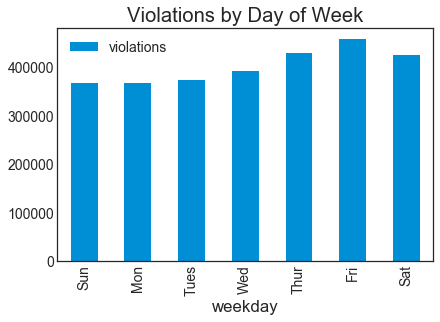

In [814]:

plt.style.use('seaborn-white')


# Weekday plot
df_weekday = signal_df.groupby(['weekday'])['violations'].sum().reset_index()
print(df_weekday.head())


ax = df_weekday.plot.bar('weekday', 'violations')
labels = ['Sun', 'Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat']
ax.set_xticklabels(labels)
ax.set_title("Violations by Day of Week")
plt.plot()

Does the month of the year have any effect on violations?
Note: Not all months have same days.  I could normalize if needed.

In [815]:
signal_df.columns

Index(['intersection', 'camera_id', 'address', 'violation_date', 'violations',
       'latitude', 'longitude', 'month', 'dat', 'weekday', 'year'],
      dtype='object')

   month  violations
0      1    4.678688
1      2    5.076703
2      3    5.413907
3      4    5.494941
4      5    6.114545


[]

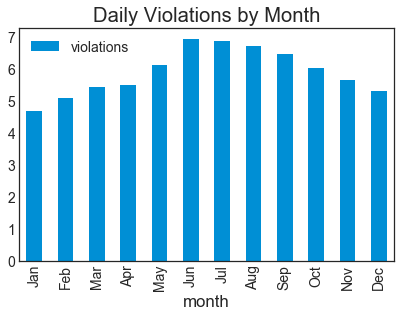

In [816]:
# Month plot
df_month = signal_df.groupby(['month'])['violations'].mean().reset_index()
print(df_month.head())

ax2 = df_month.plot.bar('month', 'violations')
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax2.set_xticklabels(labels)
ax2.set_title("Daily Violations by Month")
plt.plot()

Did the violations change by year?

Text(0.5, 1.0, 'Violations by Year')

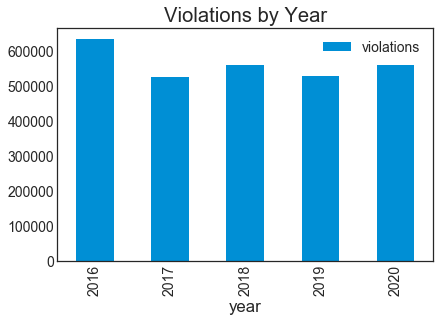

In [817]:
# Year plot
df_year = signal_df.groupby(['year'])['violations'].sum().reset_index()

ax4 = df_year.plot.bar('year', 'violations')
ax4.set_title("Violations by Year")

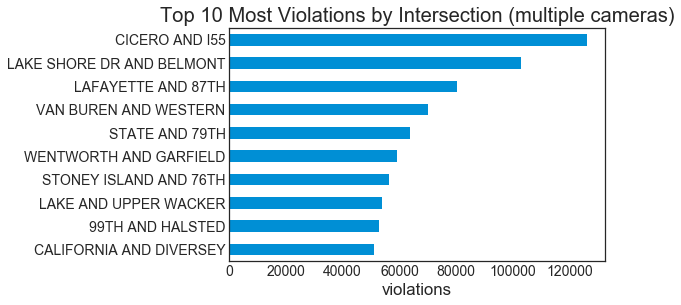

In [818]:
# top 10 plot
df_top10 = signal_df.groupby(['intersection'])['violations'].sum().reset_index()
df_top10 = df_top10.sort_values(['violations'], ascending=True).tail(10)
ax3 = df_top10.plot.barh(y='violations', x='intersection')

ax3.set_title("Top 10 Most Violations by Intersection (multiple cameras)")
ax3.set_ylabel('') # do this post plot, you have to talk to y, even in a barh
ax3.set_xlabel('violations')
ax3.get_legend().remove()

plt.show()# box plot all cameras

What does the boxplot look like for all the cameras 

<Figure size 720x576 with 0 Axes>

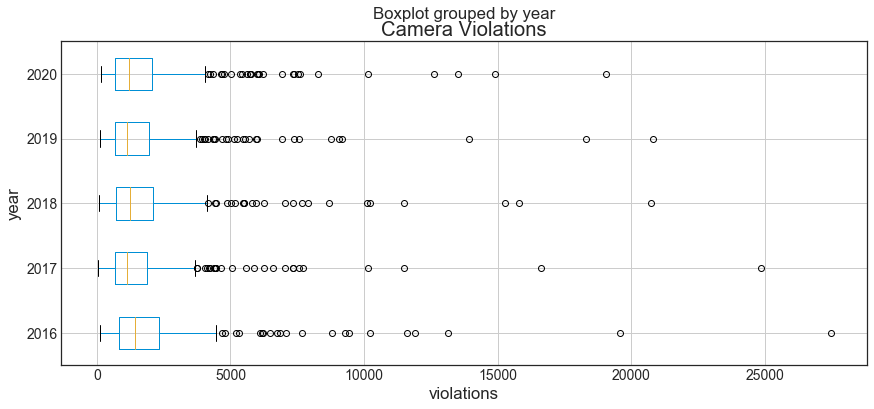

In [819]:
# plotly is not supported with boxplot

plt.figure(figsize=[10,8])
#signal_df.groupby(['camera_id'])['violations'].sum().reset_index().boxplot('violations')
#signaldf.groupby(['year', 'camera_id']).sum().reset_index().boxplot(by='year')

#signal_df.groupbyboxplot(column=['SepalLength'], by='Name', ax=ax)
signal_df.groupby(['year', 'camera_id']).sum().reset_index()[['year', 'violations']].boxplot(by='year', vert=False, figsize=[14,6])
plt.xlabel('violations')
plt.ylabel('year')
plt.title('Camera Violations')
plt.show()

# change back to plotly


In [820]:
# basic pd info
print('All Data')
print(signal_df['violations'].describe())

print('\n'*2 + 'Weekday Grouped Violations')
print(df_weekday['violations'].describe())

print('\n'*2 + 'Monthly Grouped Violations')
print(df_month['violations'].describe())


All Data
count    476354.000000
mean          5.911723
std           7.749244
min           1.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         186.000000
Name: violations, dtype: float64


Weekday Grouped Violations
count         7.000000
mean     402296.142857
std       35953.763913
min      367089.000000
25%      371380.000000
50%      392128.000000
75%      427729.500000
max      458637.000000
Name: violations, dtype: float64


Monthly Grouped Violations
count    12.000000
mean      5.892785
std       0.739975
min       4.678688
25%       5.385482
50%       5.831744
75%       6.526782
max       6.929983
Name: violations, dtype: float64


What does this look like on a map?  Does it make sense?

  camera_id                  intersection   latitude  longitude  \
0      1002            WESTERN AND CERMAK  41.851984 -87.685786   
1      1003            WESTERN AND CERMAK  41.852141 -87.685753   
2      1011          PETERSON AND WESTERN  41.990586 -87.689822   
3      1014          PETERSON AND WESTERN  41.990609 -87.689735   
4      1023  IRVING PARK AND NARRAGANSETT  41.953025 -87.786683   

                 address  violations  
0  2200 S WESTERN AVENUE        8516  
1     2400 W CERMAK ROAD        3031  
2     6000 N WESTERN AVE        6234  
3        2400 W PETERSON       11938  
4       6400 W IRVING PK        4161  


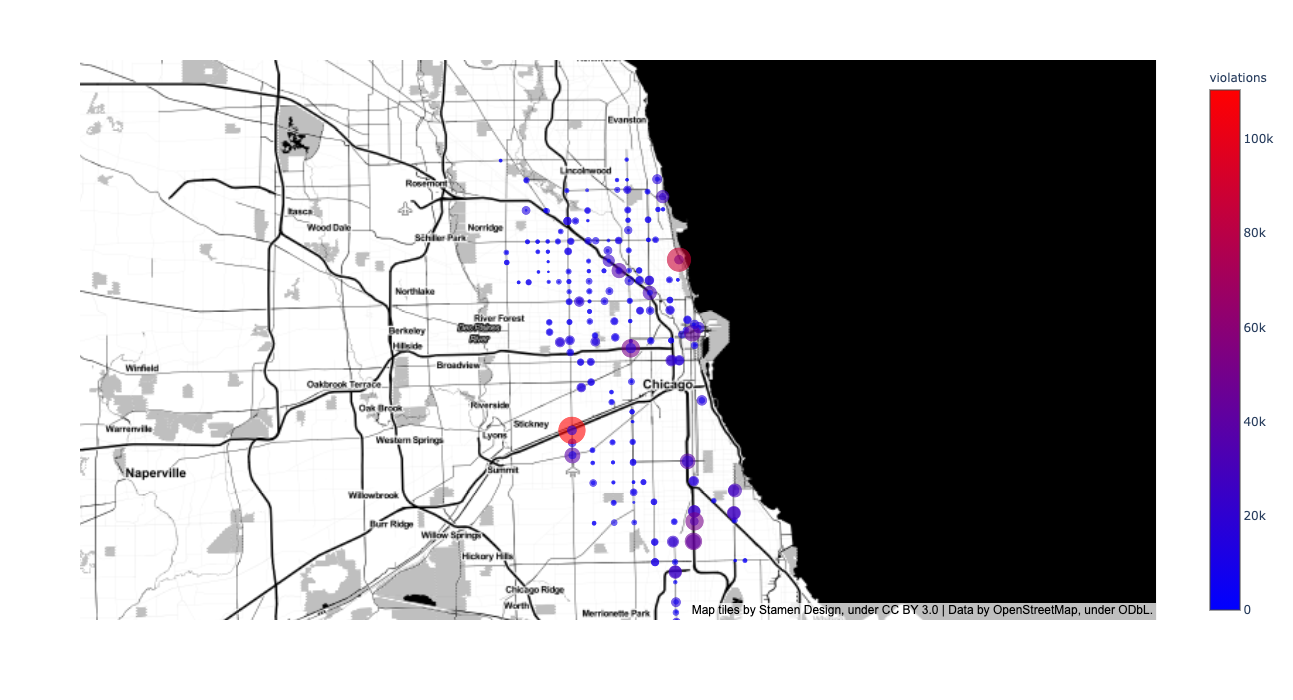

In [821]:
import plotly.express as px



df_plot = signal_df.groupby(['camera_id', 'intersection', 'latitude', 'longitude', 'address'], as_index=True)['violations'].sum().reset_index()
print(df_plot.head())
df_plot['lat'] = df_plot['latitude'].apply(lambda x: '{:.2f}'.format(x))
df_plot['long'] = df_plot['longitude'].apply(lambda x: '{:.2f}'.format(x))



# fig = px.scatter_geo(results_df.groupby('camera_id').sum(), locations="iso_alpha",
#                      color="violations", # which column to use to set the color of markers
#                      #hover_name="country", # column added to hover information
#                      size="violations", # size of markers
#                      projection="natural earth")

#px.scatter_mapbox?
fig = px.scatter_mapbox(df_plot, 
                        lat="latitude", 
                        lon="longitude", 
                        color="violations",
                        hover_name='intersection',
                        size='violations',
                        #label=['lat','long','violations'],
                        color_continuous_scale='BlueRed', 
                        #range_color=[range_min, range],
                        #center={'lat':41.975605, 'lon': -87.731670},
                        zoom=9.5,
                        opacity=0.6,
                        height=700,
                        hover_data={'camera_id':False, 'lat':False, 'long':':.2f', 'latitude':False} ,
                       )

fig.update_layout(mapbox_style="stamen-toner")  #, hoverlabel={}. MAYBE??
#fig.update_layout (textposition='top left', textfont_size=40)

#fig.update_layout(mapbox_style="open-street-map", height=800)

fig.show()


If I set it up with animation, does it add any value?  (year, month, weekday)

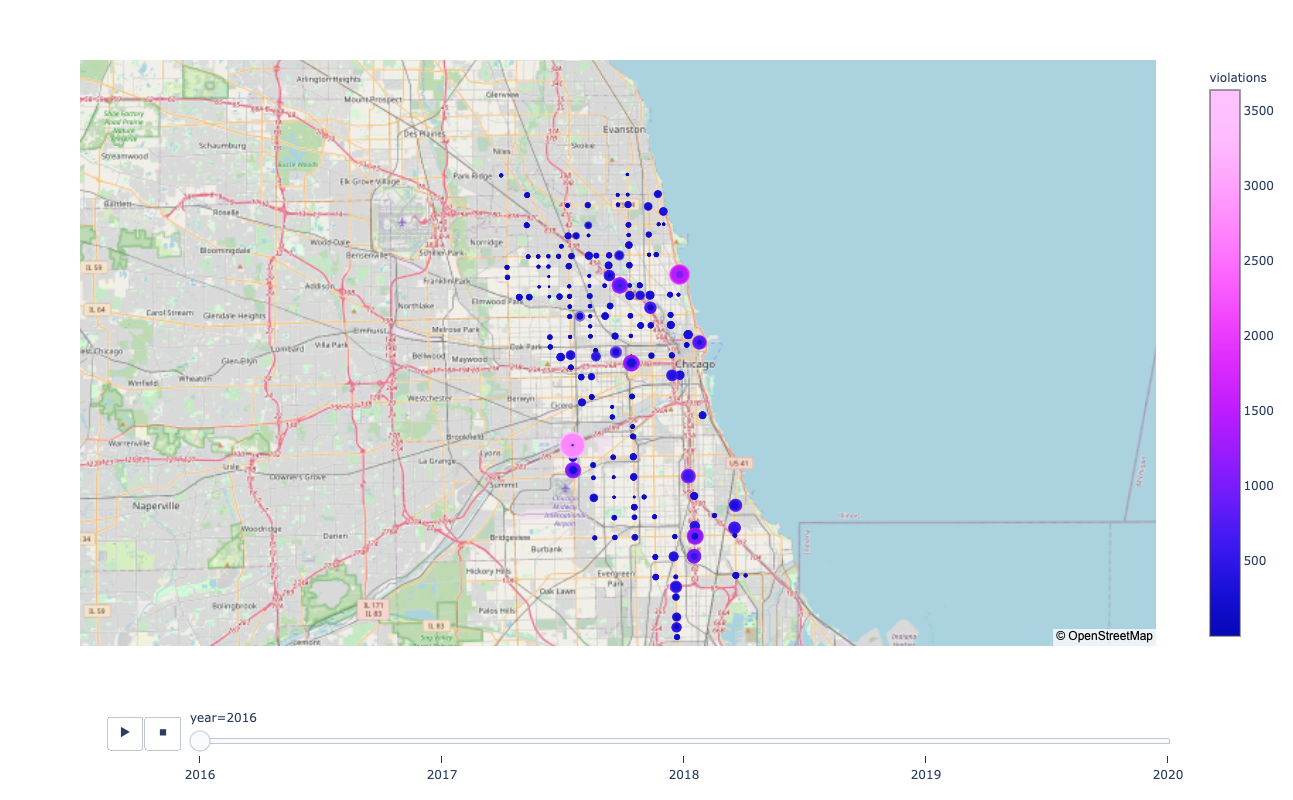

In [822]:
import plotly.express as px



df_plot = signal_df.groupby(['year', 'intersection', 'latitude', 'longitude', 'month', 'address',  'camera_id'])['violations'].sum().reset_index()
#weekday_dfs = []
#for i in range(7):
#    weekday_dfs.append(df_plot = results_df[results_df['weekday']==i])


# fig = px.scatter_geo(results_df.groupby('camera_id').sum(), locations="iso_alpha",
#                      color="violations", # which column to use to set the color of markers
#                      #hover_name="country", # column added to hover information
#                      size="violations", # size of markers
#                      projection="natural earth")

#px.scatter_mapbox?

fig = px.scatter_mapbox(df_plot, 
                        lat="latitude", 
                        lon="longitude", 
                        color="violations",
                        #text='address',
                        animation_frame='year',
                        size='violations',
                        hover_name='intersection',
                        labels=['violations', 'latitude', 'longitude'],
                        color_continuous_scale='Plotly3', 
                        #range_color=[1000, 20000],
                        #center={'lat':41.975605, 'lon': -87.731670},
                        zoom=9.5,
                        opacity=0.6,
                        
                       )
#fig.update_layout(mapbox_style="stamen-toner")
fig.update_layout(mapbox_style="open-street-map", height=800)

fig.show()

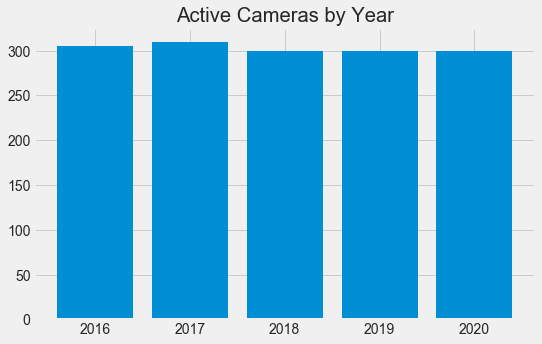

In [823]:
# how many rlc do we have by year.  Let's find out when they were OFF
import seaborn as sns
import numpy as np
plt.style.use('fivethirtyeight')

#print(results_df.groupby(['camera_id', 'year']).count().reset_index())
# how many in 2017?
year_cams = []
for year in range(2016, 2021):
    year_cams.append([year, len(signal_df[signal_df['year']==year].groupby('camera_id').count().reset_index())])
year_cams = np.array(year_cams)

plt.figure(figsize=[8,5])
plt.bar(year_cams[:,0], year_cams[:,1])
plt.title("Active Cameras by Year")
plt.show()

What about if we looked at a more granular level.  Let's go by month.  Look for big swings.

How does this compare to the number of violations during that time

In [826]:
signal_df["violation_date"] = pd.to_datetime(signal_df["violation_date"])



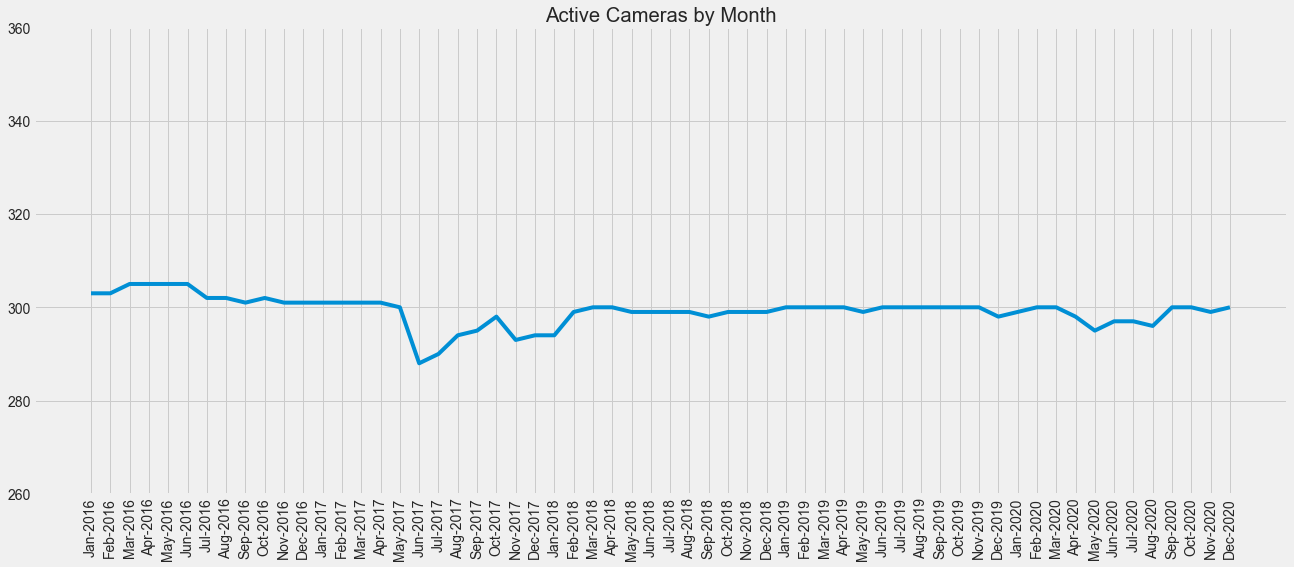

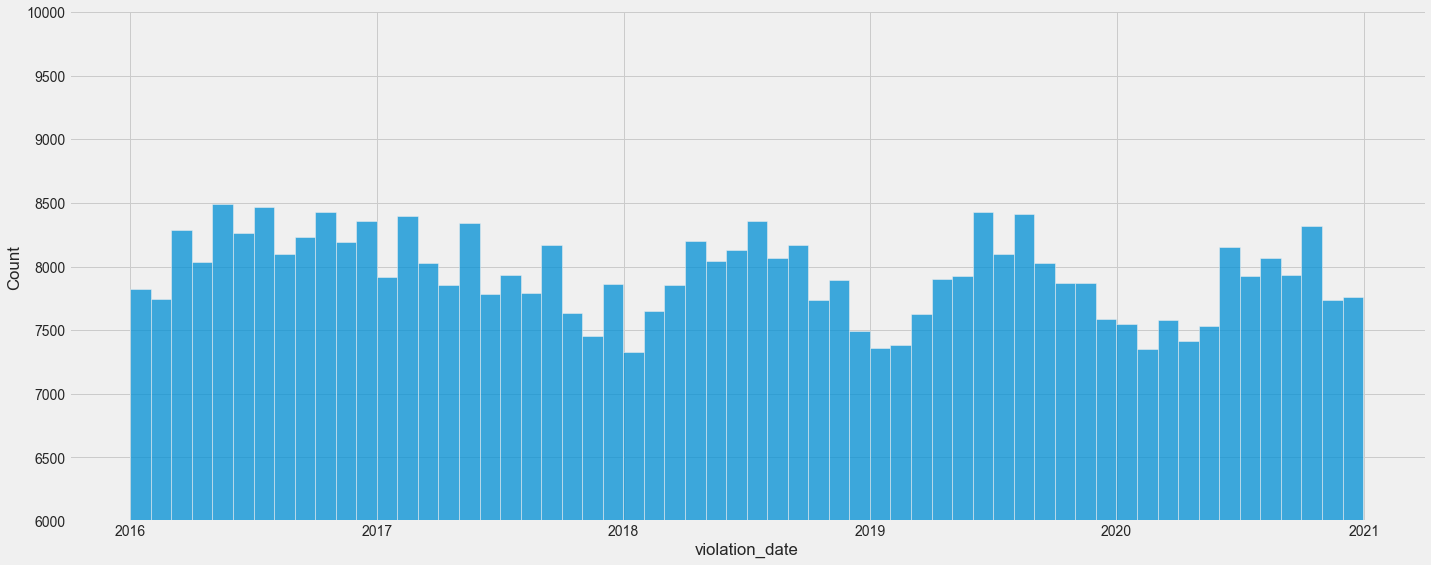

In [827]:


# lets look at a closer timeline of n cameras
month_cams = []
months = 'JanFebMarAprMayJunJulAugSepOctNovDec'
for y in range(2016, 2021):
    for m in range(1,13):
        month_cams.append([months[(m-1)*3:m*3] + "-" + str(y),
                               len(signal_df[(signal_df['year']==y) & (signal_df['month']==m)]
                                .groupby('camera_id')
                                .count()
                                .reset_index())])
month_cams = np.array(month_cams)

plt.figure(figsize=[20,8])
plt.plot([x for x in range(len(month_cams[:,1]))], month_cams[:,1].astype(np.int))
plt.xticks([x for x in range(len(month_cams[:,1]))], month_cams[:,0], rotation=90)

plt.title("Active Cameras by Month")
plt.ylim(260, 360)
plt.show()


# Now do violations per month
sns.displot(signal_df['violation_date'], 
            #kde_kws={"histtype": "step", "linewidth": 1,"alpha": 1, "color": "b"},
            bins=5*12, 
            #kde=True, 
            height=8, 
            aspect=2.5)
plt.ylim(6000, 10000)
plt.show()

Looks like we had a bunch removed in 2015, but we don't have reliable crash data for that period.
In 2016 and 2017 in particular, multiples were added/removed, thats our experiment.  

We will use intersection instead of camera_id to group our crashes and violations.

Question!!!  What are the start and end dates for each camera??? Probably need to look at each year and catch the start and end date, then label our 50+ cameras for our natural experiment.  We might not have a ton of data to work from.

Proposal:  Crashes were not recorded until 2015.  It wasn't fully mandatroy until Sept 2017 which unfortuantely is where the data is reliable.  However, we can go through every camera from 2015 to 2020 and look at the earliest date and latest date we have in the dataset.  That informs us when the camera went live or when it was shut down.  Reporting was by precinct.  The precinct is in the crash data  

Note:  In EDA, I see a lot of down time on cameras which will mess us up.  It's probably maintenance/road work/malfunction etc.  Probably need to do a check to see when camera is down.  Maybe just look at consecutive days of zero fines (maybe look as SD along with it).  Consecutive zeros can be chopped out of the dataset, or better yet... just fill in the mean for those dates.

## Crash EDA

In [828]:
all_df = pd.read_sql_query("SELECT * from all_crashes", conn)
crash_df = pd.read_sql_query("SELECT * from signal_crashes", conn)

# crash form filled out by officer (including instructions) can be found
# https://idot.illinois.gov/Assets/uploads/files/Transportation-System/Manuals-Guides-&-Handbooks/Safety/Illinois%20Traffic%20Crash%20Report%20SR%201050%20Instruction%20Manual%202019.pdf

In [848]:
# How many were at traffic signals
signal_df = all_df[all_df['traffic_control_device']=='TRAFFIC SIGNAL']
other_df = all_df[(all_df['traffic_control_device']!='TRAFFIC SIGNAL') | (all_df['intersection_related_i']!='Y')]
intrel_df = all_df[(all_df['intersection_related_i']=='Y')]
df = all_df[(all_df['intersection_related_i']=='Y')&(all_df['traffic_control_device']=='TRAFFIC SIGNAL')]

# how many crashes are at signals?
print('{:<25}{:<15}{:20}'.format('', 'n crash', 'Percent of total'))
print('{:<25}{:<15,}{:<20}'.format('All in study', len(all_df), '100.0%'))
print('{:<25}{:<15,}{:<4.1f}%'.format('At traffic signal', len(signal_df), len(signal_df)/len(all_df)*100))
print('{:<25}{:<15,}{:.1f}%'.format('Intersection-related', 
                                                    len(intrel_df), 
                                                    len(intrel_df)/len(all_df)*100
                                )
     )

print('{:<25}{:<15,}{:.1f}%'.format('Signal AND Intersection', 
                                                    len(df), 
                                                    len(df)/len(all_df)*100
                                )
     )

                         n crash        Percent of total    
All in study             463,814        100.0%              
At traffic signal        129,353        27.9%
Intersection-related     99,846         21.5%
Signal AND Intersection  60,333         13.0%


In [849]:
# what kind of crashes occur at traffic light, and how does it compare to other crashes?

def crash_stats(all_df, df):
    # by percentages
    crash_types = df['first_crash_type'].unique()

    print_list = []
    print('{:30}{:15}{:20}'.format("Type of Crash", 'Total crashes','Percent of total'))
    for crash in crash_types:
        num_crashes = len(df[df['first_crash_type']==crash])
        print_list.append([crash, num_crashes])
    
    print_list = sorted(print_list, key=lambda x: x[1], reverse=True)
    
    for crash, n in print_list: 
        print('{:30}{:<15d}{:>5.1f}%'.format(crash, n, 100 * n / len(df)))

def print_header(message):
    print('--'*20)
    print(message)
    print('--'*20)
        
def print_crash_stats(all_df, signal_df, other_df, signal_int_df):
    '''
    all_df Dataframe: all crashes in study 
    signal_df Dataframe: all signal related crashes
    other_df Dataframe: all non-signal related crahses
    signal_int_df: both signal and intersection related crashes
    '''
    print('CRASH STATS')
    print('Total crashes in study:', len(all_df))
    print('Signal crashes: {:.1f}%'.format((100 * len(signal_df) / len(all_df))))

    print_header('ALL CRASHES')
    print('Total crashes:', len(other_df))
    print()
    crash_stats(all_df, other_df)
    print('\n\n')
    
    
    print_header('CRASHES AT SIGNAL')
    print('Total crashes:', len(signal_df))
    print()
    crash_stats(all_df, signal_df)
    print('\n\n')

    
    print_header('CRASHES AT SIGNAL AND INTERSECTION RELATED')
    print('Total crashes:', len(signal_int_df))
    print()
    crash_stats(all_df, signal_int_df)
    

        

        
print_crash_stats(all_df, signal_df, other_df, df)


CRASH STATS
Total crashes in study: 463814
Signal crashes: 27.9%
----------------------------------------
ALL CRASHES
----------------------------------------
Total crashes: 403481

Type of Crash                 Total crashes  Percent of total    
PARKED MOTOR VEHICLE          105420          26.1%
REAR END                      94932           23.5%
SIDESWIPE SAME DIRECTION      64663           16.0%
TURNING                       45011           11.2%
ANGLE                         39540            9.8%
FIXED OBJECT                  19799            4.9%
PEDESTRIAN                    8130             2.0%
SIDESWIPE OPPOSITE DIRECTION  6276             1.6%
PEDALCYCLIST                  5647             1.4%
OTHER OBJECT                  4264             1.1%
HEAD ON                       3447             0.9%
REAR TO FRONT                 2278             0.6%
OTHER NONCOLLISION            1504             0.4%
REAR TO SIDE                  1448             0.4%
REAR TO REAR            

## Most dangerous crash types at intersections

In [850]:
for mydf in [all_df, signal_df, other_df, df]:
    mydf['injuries_total'].isna().sum()
    mydf['injuries_total'].fillna(0, inplace=True) # assume no injuries if left blank

    mydf['injuries_fatal'].isna().sum()
    mydf['injuries_fatal'].fillna(0, inplace=True) # assume no deaths if left blank

    mydf['injuries_total'] = all_df['injuries_total'].astype('int')
    mydf['injuries_fatal'] = all_df['injuries_fatal'].astype('int')


#all_df.injuries_total.sum()r


In [868]:
# what kind of crashes occur at traffic light, and how does it compare to other crashes?

def crash_stats2(df):
    # by percentages
    crash_types = df['first_crash_type'].unique()

    print_list = []
    
    
    print()
    print('{:30}{:15}{:20}{:20}{:20}{:20}'.format("Type of Crash", 'Total Crashes', 'Injuries', 'Injuries/Crash', 'Deaths', 'Deaths/Crash'))
    for crash in crash_types:
        num_crashes = len(df[df['first_crash_type']==crash])
        num_injuries = df[df['first_crash_type']==crash]['injuries_total'].sum()
        num_deaths = df[df['first_crash_type']==crash]['injuries_fatal'].sum()
        print_list.append([crash, num_crashes, num_injuries, num_deaths])
    
    print_list = sorted(print_list, key=lambda x: x[1], reverse=True)
    
    

    for crash, n, injuries, deaths in print_list: 
        print('{:30}{:<15d}{:<20}{:<20.2f}{:<20}{:<20.5f}'.format(crash, n, injuries, injuries/n, deaths, deaths/n))
    
    return print_list

def all_stats(message, df):
        print('{:30}{:<15d}{:<20}{:<20.2f}{:<20}{:<20.5f}'.format(message, 
                                                                      len(df), 
                                                                      df['injuries_total'].sum(), 
                                                                      df['injuries_total'].sum()/len(df),
                                                                      df['injuries_fatal'].sum(), 
                                                                      df['injuries_fatal'].sum()/len(df)))
        

def print_crash_stats2(all_df, signal_df, other_df, signal_int_df):
    '''
    all_df Dataframe: all crashes in study 
    signal_df Dataframe: all signal related crashes
    other_df Dataframe: all non-signal related crahses
    signal_int_df: both signal and intersection related crashes
    '''
    print('CRASH STATS')
    print()
    
   

    all_stats('ALL OTHER CRASHES', other_df)
    
    # First, we print the stats for all crashes
    crash_stats2(all_df)
    print('\n\n')
    
    print_header('CRASHES AT SIGNAL AND INTERSECTION RELATED')
    
    
    all_stats('ALL SIGNAL & INTERSECTION CRASHES', signal_int_df)

    print()
    crash_stats2(signal_int_df)
    
    

        

        
print_crash_stats2(all_df, signal_df, other_df, df)




CRASH STATS

ALL OTHER CRASHES             403481         60142               0.15                381                 0.00094             

Type of Crash                 Total Crashes  Injuries            Injuries/Crash      Deaths              Deaths/Crash        
REAR END                      111398         19612               0.18                18                  0.00016             
PARKED MOTOR VEHICLE          105848         3960                0.04                51                  0.00048             
SIDESWIPE SAME DIRECTION      71880          4571                0.06                15                  0.00021             
TURNING                       64977          14324               0.22                32                  0.00049             
ANGLE                         49099          15926               0.32                55                  0.00112             
FIXED OBJECT                  20960          4404                0.21                141                

In [871]:
print('Crashes involving signaled intersections:')
print('\t{:.1%} of all crashes'.format(len(df) / len(all_df)))
print('\t{:.1%} of all injuries'.format(df['injuries_total'].sum() / all_df['injuries_total'].sum()))
print('\t{:.1%} of all deaths'.format(df['injuries_fatal'].sum() / all_df['injuries_fatal'].sum()))
print()

Crashes involving signaled intersections:
	13.0% of all crashes
	26.4% of all injuries
	22.2% of all deaths




Type of Crash                 Total Crashes  Injuries            Injuries/Crash      Deaths              Deaths/Crash        
TURNING                       19966          6136                0.31                21                  0.00105             
REAR END                      16466          3737                0.23                5                   0.00030             
ANGLE                         9559           6501                0.68                40                  0.00418             
SIDESWIPE SAME DIRECTION      7217           555                 0.08                4                   0.00055             
PEDESTRIAN                    2734           2603                0.95                17                  0.00622             
PEDALCYCLIST                  1264           932                 0.74                5                   0.00396             
FIXED OBJECT                  1161           424                 0.37                15                  0.01292     

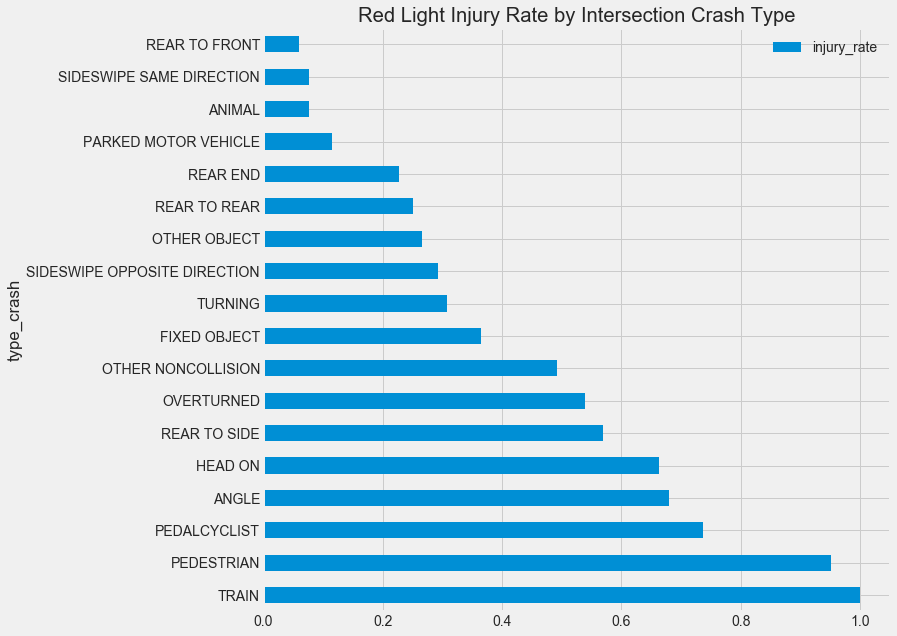

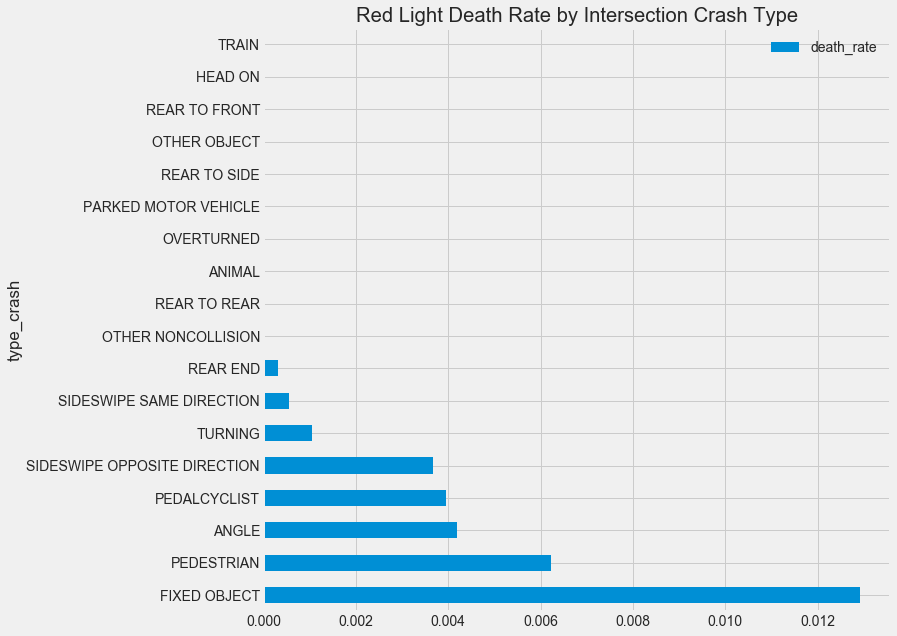

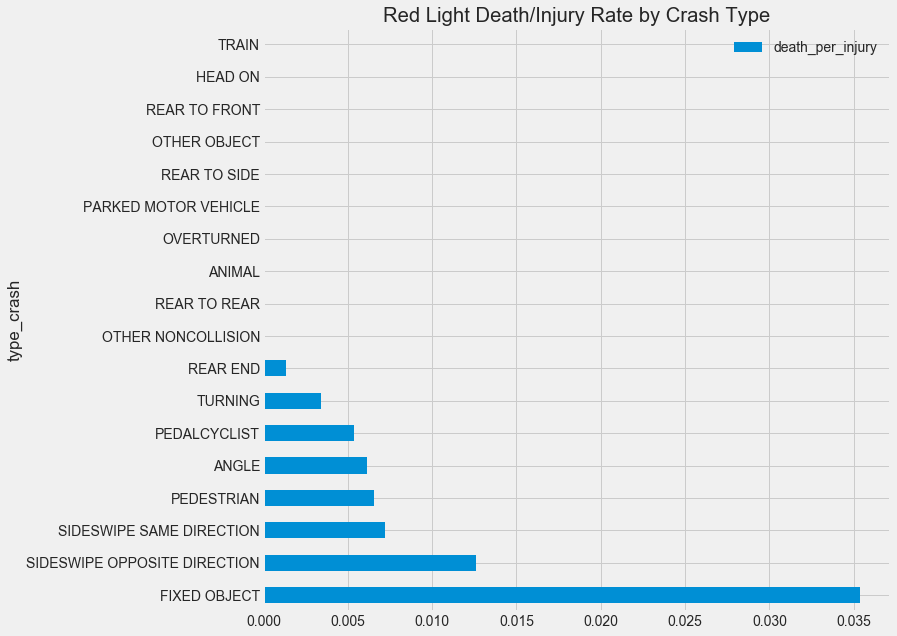

In [872]:
plot_list = crash_stats2(df)

plot_df = pd.DataFrame(plot_list, columns=['type_crash', 'n_crashes', 'injuries', 'deaths'])
plot_df['injury_rate'] = plot_df['injuries']/plot_df['n_crashes']
plot_df['death_rate'] = plot_df['deaths']/plot_df['n_crashes']
plot_df['death_per_injury'] = plot_df['deaths']/plot_df['injuries']

print()
plot_df[['type_crash','injury_rate']].sort_values(by='injury_rate',ascending=False).plot.barh(x='type_crash',
                                                                                              y='injury_rate',
                                                                                              figsize=[10,10],
                                                                                              title='Red Light Injury Rate by Intersection Crash Type',
                                                                                             )
                                                

plt.show()
plot_df[['type_crash','death_rate']].sort_values(by='death_rate',ascending=False).plot.barh(x='type_crash',
                                                                                            y='death_rate',
                                                                                            figsize=[10,10], 
                                                                                            title='Red Light Death Rate by Intersection Crash Type',
                                                                                           )

plt.show()
plot_df[['type_crash','death_per_injury']].sort_values(by='death_per_injury',ascending=False).plot.barh(x='type_crash',
                                                                                            y='death_per_injury',
                                                                                            figsize=[10,10], 
                                                                                            title='Red Light Death/Injury Rate by Crash Type',
                                                                                           )

Chicago gov website claims that red light cameras are there to decrease the rate of crashes.
Are the red light cams actually at most dangerous intersections?  

## Red light intersections vs. all Others
Chicago has 3035 traffic intersections with lights
176 have red light cams at them.
We would assume these to be the most dangerous intersections in the city.
https://www.chicago.gov/city/en/depts/cdot/provdrs/traffic_signals_andstreetlights/svcs/traffic_signals.html

In [873]:
# Get only intersections with total crashes and violations
# had to use a windowed query on this one

int_crash_violations_df = pd.read_sql_query('''
                            WITH cr AS
                               (SELECT intersection, 
                                       COUNT(crash_record_id) as total_crashes,
                                       SUM(injuries_total) as total_injuries, 
                                       SUM(injuries_fatal) as total_deaths
                               FROM signal_crashes
                               GROUP BY intersection)
                            SELECT cr.intersection, total_crashes, SUM(v.violations) as total_violations, cr.total_injuries, cr.total_deaths
                            FROM cr
                            LEFT JOIN daily_violations v
                               ON v.intersection=cr.intersection
                            GROUP BY cr.intersection
                            ORDER BY total_crashes DESC;
                           ''', conn)




In [887]:
int_crash_violations_df.head(50)

#int_crash_violations_df.total_crashes.sum()


total_intersections = 3035
total_rlc = len(int_crash_violations_df)-1
rlc_accidents = int_crash_violations_df[int_crash_violations_df['intersection'].isna()]['total_crashes'].sum()
total_accidents = int_crash_violations_df['total_crashes'].sum()
total_deaths = int_crash_violations_df.total_deaths.sum()
total_injuries = int_crash_violations_df.total_injuries.sum()
other_deaths = int_crash_violations_df[int_crash_violations_df['intersection'].isna()]['total_deaths'].sum()
other_injuries = int_crash_violations_df[int_crash_violations_df['intersection'].isna()]['total_injuries'].sum()
#print(rlc_accidents, total_accidents)

print('No red light cam intersections:')
print('{:.2%} of all red light intersections'.format(1 - total_rlc/total_intersections))
print('{:.2%} of all red light accidents'.format(rlc_accidents/total_accidents))
print('{:.2%} of all red light deaths'.format(other_deaths/total_deaths))
print('{:.2%} of all red light injuries'.format(other_injuries/total_injuries))
print('Deaths: {}  Injuries: {}'.format(other_deaths, other_injuries))


print()
print('Red light cam intersections:')
print('{:.2%} of all red light intersections'.format(total_rlc/total_intersections))
print('{:.2%} of all red light accidents'.format(1 - rlc_accidents/total_accidents))
print('{:.2%} of all red light deaths'.format(1-other_deaths/total_deaths))
print('{:.2%} of all red light injuries'.format(1 - other_injuries/total_injuries))
print('Deaths: {} Injuries: {}'.format(total_deaths-other_deaths, total_injuries-other_injuries))


No red light cam intersections:
94.07% of all red light intersections
88.12% of all red light accidents
85.32% of all red light deaths
87.73% of all red light injuries
Deaths: 93  Injuries: 18915

Red light cam intersections:
5.93% of all red light intersections
11.88% of all red light accidents
14.68% of all red light deaths
12.27% of all red light injuries
Deaths: 16 Injuries: 2646


Red light cameras exist at intersections that are more dangerous, or perhaps at least more used than typical

In [891]:
print(df.columns)
sql_fetch_tables(c, conn)

Index(['crash_record_id', 'rd_no', 'crash_date', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'hit_and_run_i', 'damage', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'crash_hour',
       'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'lane_cnt',
       'intersection_related_i', 'crash_date_est_i', 'work_zone_i',
       'work_zone_type', 'workers_present_i'],
      dtype='object')


[('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('intersction_locations',),
 ('intersection_cams',),
 ('all_crashes',),
 ('hourly_congestion',),
 ('hourly_weather',),
 ('region_data',),
 ('signal_crashes',)]

In [898]:
type_crash = pd.read_sql_query('''
                            WITH cr AS
                               (SELECT first_crash_type as crash_type,
                                       SUM(injuries_total) as total_injuries, 
                                       SUM(injuries_fatal) as total_deaths,
                                       COUNT(crash_record_id) as total_crashes
                               FROM signal_crashes
                               GROUP BY first_crash_type)
                            SELECT cr.crash_type, cr.total_crashes, cr.total_injuries, cr.total_deaths
                            FROM cr
                            GROUP BY cr.crash_type
                            ORDER BY cr.total_crashes DESC;
                           ''', conn)

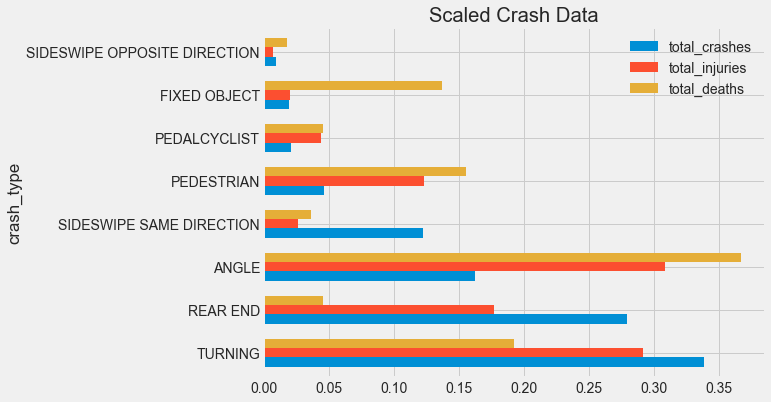

In [900]:
# USING MINMAX SCALING TO COMPARE

type_crash['total_crashes'] = type_crash['total_crashes']/type_crash.total_crashes.sum()
type_crash['total_injuries'] = type_crash['total_injuries']/type_crash.total_injuries.sum()
type_crash['total_deaths'] = type_crash['total_deaths']/type_crash.total_deaths.sum()

# Remove any crash type with no deaths
type_crash = type_crash[type_crash['total_deaths'] > 0]

type_crash.sort_values(by='total_crashes',ascending=False).plot.barh(x='crash_type', 
                                                                     figsize=[8,6], 
                                                                     title='Scaled Crash Data', 
                                                                     width=0.65
                                                                    )

## Which cams were turned one an off between 2016 and 2020 

#### Do cameras with start/end dates have common intersections?

In [901]:
# FIRST HALF OF WHAT I WANT
cams_interest = pd.read_sql_query('''SELECT camera_id, intersection, start, end
                                     FROM cam_startend ends
                                     LEFT JOIN intersection_cams ic
                                         ON ends.camera_id=ic.cam1
                                         OR ends.camera_id=ic.cam2
                                         OR ends.camera_id=ic.cam3
                                     ORDER BY intersection
                                    ''', conn)

# THIS ISN"T QUITE IT
cams_interest = pd.read_sql_query('''WITH c as
                                        (SELECT ends.camera_id as camera_id, 
                                                ic.intersection as intersection, 
                                                start, 
                                                end
                                         FROM cam_startend ends
                                         LEFT JOIN intersection_cams ic
                                             ON ends.camera_id=ic.cam1
                                             OR ends.camera_id=ic.cam2
                                             OR ends.camera_id=ic.cam3
                                         )
                                     SELECT c.camera_id, 
                                            c.intersection, 
                                            c.start, 
                                            c.end, 
                                            COUNT(cr.crash_record_id) as n_crashes, 
                                            SUM(injuries_total) as injuries_total, 
                                            SUM(injuries_fatal) as injuries_fatal
                                     FROM c
                                     LEFT JOIN signal_crashes cr
                                         ON c.intersection=cr.intersection
                                    GROUP BY c.intersection
                                    ORDER BY c.intersection
                                    ''', conn)

#TRY3
cams_interest = pd.read_sql_query('''
                                    WITH cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT cr.intersection, cr.n_crash, cr.injuries, cr.deaths
                                    FROM cr
                                    GROUP BY cr.intersection
                                         
                                    ''', conn)

#TRY4. Getting there
# learned that you only need one with statement (don't forget a comma between windows)
cams_interest = pd.read_sql_query('''
                                    WITH v as
                                        (SELECT intersection,
                                                sum(violations) as violations
                                        FROM daily_violations
                                        GROUP BY intersection
                                        ),
                                    cr as
                                        (SELECT intersection,
                                                COUNT(crash_record_id) as n_crash,
                                                SUM(injuries_total) as injuries,
                                                SUM(injuries_fatal) as deaths
                                         FROM signal_crashes
                                         GROUP BY intersection
                                         ORDER BY intersection
                                         )
                                    SELECT v.intersection, v.violations, cr.n_crash, cr.injuries, cr.deaths
                                    FROM v
                                    LEFT JOIN cr
                                        ON cr.intersection=v.intersection
                                    GROUP BY v.intersection
                                         
                                    ''', conn)

                          
                                        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 5 columns):
intersection    183 non-null object
violations      183 non-null int64
n_crash         180 non-null float64
injuries        180 non-null float64
deaths          180 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 7.3+ KB


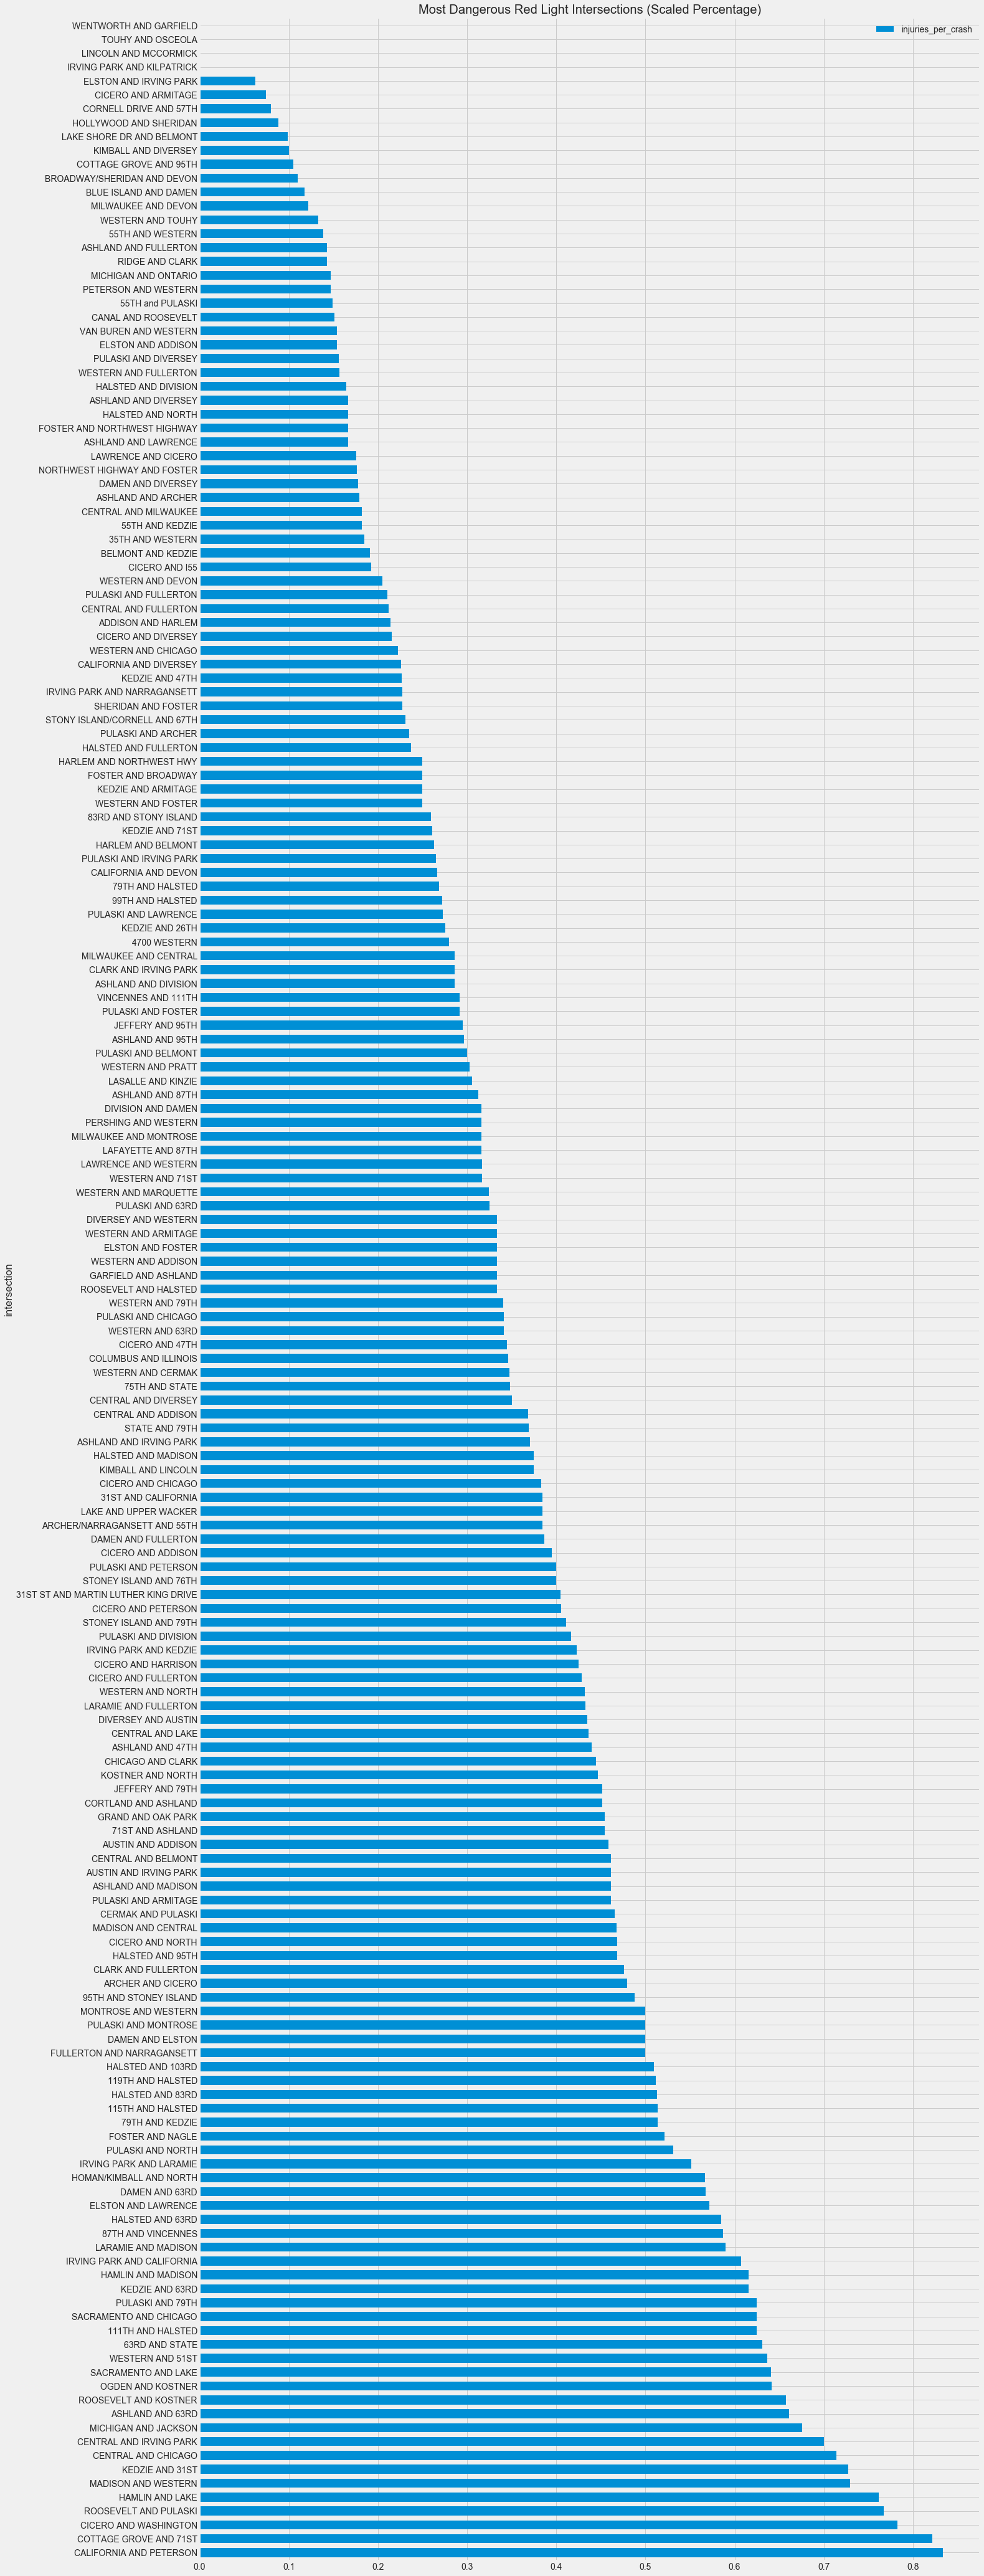

In [902]:
# Now we have every camera with every intersection with every startend
# We need to add in 

# cams_interest['start'] = pd.to_datetime(cams_interest.start)
# cams_interest['end'] = pd.to_datetime(cams_interest.end)

cams_interest.info()
cams_interest.head()

# most dangerous intersections
df_plot = cams_interest[cams_interest['intersection'].notnull()]
df_plot['injuries_per_crash'] = df_plot['injuries'] / df_plot['n_crash']
df_plot['violations'] = df_plot['violations'] / df_plot['violations'].sum()

#df_plot['n_crash'] = df_plot['n_crash'] / df_plot['n_crash'].sum()
#df_plot['injuries'] = df_plot['injuries'] / df_plot['injuries'].sum()
#df_plot['deaths'] = df_plot['deaths'] / df_plot['deaths'].sum()


df_plot[['intersection', 'injuries_per_crash']].sort_values(by='injuries_per_crash',ascending=False).plot.barh(x='intersection', 
                                                                     figsize=[20,70], 
                                                                     title='Most Dangerous Red Light Intersections (Scaled Percentage)', 
                                                                     width=0.65
                                                                    )

In [903]:
int_df[int_df['intersection'] == 'LAKE SHORE DR AND BELMONT']  # no crashes, weird
#signal_df[signal_df['intersection'] == 'WENTWORTH AND GARFIELD']  # no crashes, weird
#sql_fetch_tables(c, conn)

#int_df = pd.read_sql_query("SELECT * from intersection_cams", conn)


intersection   latitude  longitude  cam1  cam2  cam3
119  LAKE SHORE DR AND BELMONT  41.940909 -87.639369  1412  1413  None

In [905]:
print(int_df[int_df['intersection'] == 'LINCOLN AND MCCORMICK'])  # OH, THAT'S WHY!!!!  WRONG LOCATION LISTED IN DATASET!!!

# Ones that had no accidents but checked out (TOUHY AND OSCEOLA, )
correct_camlocs = {'WENTWORTH AND GARFIELD': (41.79435532184194, -87.63114616279303),
                   'KIMBALL AND LINCOLN': (41.99454797825689, -87.71403619467101),
                    'IRVING PARK AND LARAMIE': (41.95330280770521, -87.75714705140294),
                   'IRVING PARK AND KILPATRICK': (41.953454972337305, -87.74460631799197),
                   '31ST ST AND MARTIN LUTHER KING DRIVE':(41.838438059816816, -87.61731906497867),
                   '31ST AND CALIFORNIA':(41.83743605501678, -87.6950324427879),
                   'ELSTON AND LAWRENCE': (41.96809435761252, -87.74010862196117),
                   'OGDEN AND KOSTNER':(41.84767736575193, -87.73437725628261),
                    'IRVING PARK AND CALIFORNIA':(41.95399037931945, -87.69821479681646),
                   'LAKE SHORE DR AND BELMONT': (41.940128786177176, -87.63954362976928),
                     }

int_df.intersection.unique()



              intersection  latitude  longitude  cam1  cam2  cam3
125  LINCOLN AND MCCORMICK  41.99445 -87.714208  2751  None  None


array(['111TH AND HALSTED', '115TH AND HALSTED', '119TH AND HALSTED',
       '31ST AND CALIFORNIA', '31ST ST AND MARTIN LUTHER KING DRIVE',
       '35TH AND WESTERN', '4700 WESTERN', '55TH AND KEDZIE',
       '55TH AND WESTERN', '55TH and PULASKI', '63RD AND STATE',
       '71ST AND ASHLAND', '75TH AND STATE', '79TH AND HALSTED',
       '79TH AND KEDZIE', '83RD AND STONY ISLAND', '87TH AND VINCENNES',
       '95TH AND STONEY ISLAND', '99TH AND HALSTED', 'ADDISON AND HARLEM',
       'ARCHER AND CICERO', 'ARCHER/NARRAGANSETT AND 55TH',
       'ASHLAND AND 47TH', 'ASHLAND AND 63RD', 'ASHLAND AND 87TH',
       'ASHLAND AND 95TH', 'ASHLAND AND ARCHER', 'ASHLAND AND DIVERSEY',
       'ASHLAND AND DIVISION', 'ASHLAND AND FULLERTON',
       'ASHLAND AND IRVING PARK', 'ASHLAND AND LAWRENCE',
       'ASHLAND AND MADISON', 'AUSTIN AND ADDISON',
       'AUSTIN AND IRVING PARK', 'BELMONT AND KEDZIE',
       'BLUE ISLAND AND DAMEN', 'BROADWAY/SHERIDAN AND DEVON',
       'CALIFORNIA AND DEVON', 'CALI

In [906]:
cams_interest.deaths.sum()  # it matches previous result.  This is all deaths though.

16.0

In [907]:
sql_fetch_tables(c, conn)

[('cam_locations',),
 ('cam_startend',),
 ('daily_violations',),
 ('intersction_locations',),
 ('intersection_cams',),
 ('all_crashes',),
 ('hourly_congestion',),
 ('hourly_weather',),
 ('region_data',),
 ('signal_crashes',)]

# Weather EDA

In [908]:
print('Total potential wx entries:', len(weather_df) * 29)  # if every weather entry had every region
print('Total congestion entries:', len(congestion_df))
print()

for year in range(2015, 2021):
    print(year, 'traffic entries:', len(congestion_df[congestion_df['year']==year]))
    print(year, 'weather entries:', len(weather_df[weather_df['year']==year]) * 29)
    print()
    

# we have more wx data than congestion.  Consider dropping 2015?
# it makes sense to have slightly more weather entries.  
# Not all regions have buses running 24/7.  Could also have missing data

Total potential wx entries: 1504752
Total congestion entries: 1331680

2015 traffic entries: 88740
2015 weather entries: 254040

2016 traffic entries: 250473
2016 weather entries: 254736

2017 traffic entries: 251517
2017 weather entries: 254040

2018 traffic entries: 248965
2018 weather entries: 254040

2019 traffic entries: 242208
2019 weather entries: 254040

2020 traffic entries: 249777
2020 weather entries: 233856



# Congestion EDA

In [923]:
congestion_df = pd.read_sql_query('''SELECT * 
                                  FROM hourly_congestion
                                  WHERE year > 2015
                                  ''', conn)


In [924]:
# clean up congestion to fill in the missing overnight data with mean
congestion_df.speed.isna().sum()

print('Congestion rows with speed of zero: {:.2f}%'.format(congestion_df[congestion_df['speed']==0].count()[0] / len(congestion_df) * 100))



def speed_fix(speed, hour):
    # there is no significant congestion before 5am in Chicago.
    # there are however a significant amount of buses sitting still before starting routes
    if speed < 20 and 0 < hour < 5 or speed > 50:
        return 28
    else:
        return speed

#congestion_df.speed.replace(0, congestion_df.speed.mean(), inplace=True)
# takes a few minutes to fix the speed discrepancy  

############### MOVE ME TO PREPROCESSING  ######################
congestion_df['speed'] = congestion_df.apply(lambda x: speed_fix(x.speed, x.hour), axis=1)

Congestion rows with speed of zero: 0.00%


In [925]:
congestion_df.columns

Index(['year', 'month', 'day', 'hour', 'region_id', 'bus_count', 'num_reads',
       'speed', 'weekday'],
      dtype='object')

In [941]:
hourly_congestion = congestion_df.drop(['region_id'], axis=1).groupby(['year', 'month', 'day', 'hour', 'weekday']).agg({'bus_count':'sum', 'num_reads':'sum', 'speed':np.mean}).reset_index()

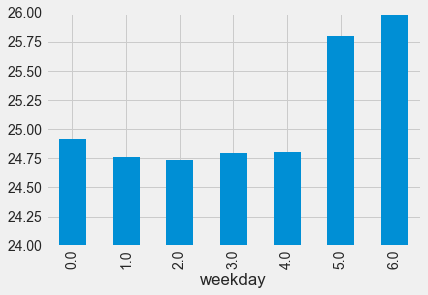

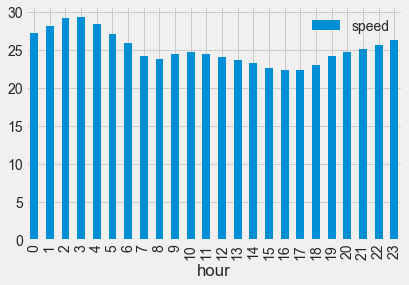

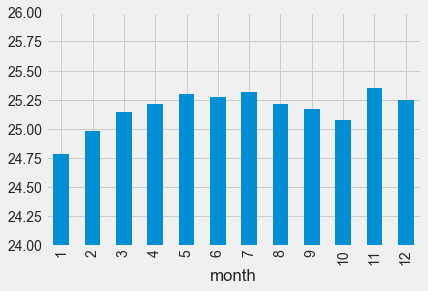

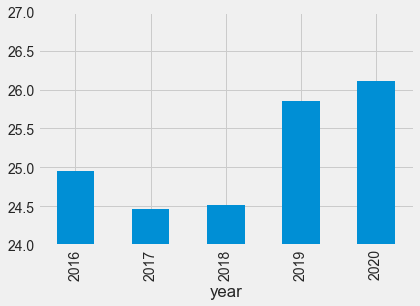

In [956]:
hourly_congestion[['weekday', 'speed']].groupby('weekday').mean().plot.bar(legend=False, ylim=[24,26])
hourly_congestion[['hour', 'speed']].groupby('hour').mean().plot.bar()
hourly_congestion[['month', 'speed']].groupby('month').mean().plot.bar(legend=False, ylim=[24,26])
hourly_congestion[['year', 'speed']].groupby('year').mean().plot.bar(legend=False, ylim=[24,27])


Holidays could be a consideration.  Look at Nov/Dec.

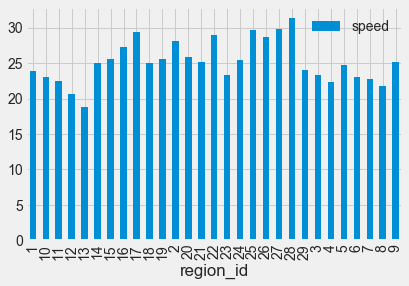

In [958]:
region_congestion = congestion_df.groupby(['region_id']).agg({'speed':np.mean}).reset_index()
region_congestion.plot.bar('region_id')



Looking at the mean speed by region, we see that we have to account for region if we use congestion. 
We will probably have to scale it by region so we can fairly compare and use congestion/speed in our model.  Check if we added region_id